Si tienen conda instalado, hay que correr:

conda env create --name widgets --file wid-env.txt

si todo sale bien, correr:

`conda activate widgets`

`python -m ipykernel install --user --name widgets --display-name "widg"`

Si todo sale bien, pueden correr:

`jupyter-lab`

En el menú `Kernel` seleccionar `Change Kernel` y elegir `widg` si no está seleccionado por defecto





Es importante ir a Kernel>Restart Kernel cada cierto tiempo, van a notar que si queda abierto mucho rato se hace lento.

In [1]:
import ipywidgets as widgets
from ipywidgets.widgets import HBox,VBox
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive, interactive_output
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import clear_output

In [2]:
#Es necesario correr esta celda
def mask_line(x,y,a,b):
    x_ma=np.ma.masked_outside(x,a,b)
    mask = np.ma.getmask(x_ma)
    f_ma=np.ma.array(y,mask=mask)    
    return x_ma,f_ma
def gaussian(x,cont,inten,m,sigma):
    return cont - inten*np.exp(-((x-m)/sigma)**2)
def gaussians(x,cont,inten1,m1,sigma1,inten2,m2,sigma2):
    return cont - inten1*np.exp(-((x-m1)/sigma1)**2) - inten2*np.exp(-((x-m2)/sigma2)**2)

# Widgets

## Ejemplos de widgets

In [ ]:
#Algunos widgets

In [4]:
widgets.IntSlider(min=2,max=11,step=1,value=3,description='Oscar')

IntSlider(value=3, description='Oscar', max=11, min=2)

In [5]:
a = widgets.FloatText()
b = widgets.FloatSlider(readout_format='.2f',step=0.1)
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

In [6]:
c = widgets.FloatText(readout_format='.2f')
display(b,c)

mylink = widgets.jslink((b, 'value'), (c, 'value'))

FloatSlider(value=0.0)

FloatText(value=0.0)

In [ ]:
c=widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
display(c)

# Plot interactivo

## Una gaussiana

Generamos un vector entre 128 y 132 de 2000 puntos

creo una linea falsa, la funcion `gaussian` genera un continuo menos una gaussiana (una linea artificial)

np.random.normal genera un vector de 2000 con valores de ruido gaussiano, centrado en 0.00 y dispersion 0.005

al sumarlos parece una linea falsa.

`np.ma.masked_outside` nos deja elegir un rango que vamos a elegir más adelante

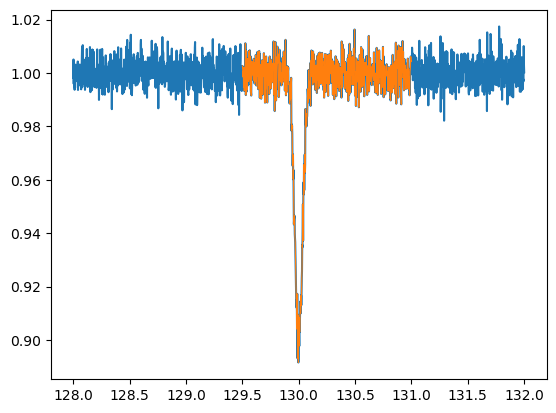

In [3]:
xx0 = np.linspace(128, 132, num=2000)
faux0=gaussian(xx0,cont=1,inten=0.1,m=130,sigma=0.05)+np.random.normal(0.00,0.005,2000)
masked0=np.ma.masked_outside(xx0,129.5,131)
mask0 = np.ma.getmask(masked0)
fauma0=np.ma.array(faux0,mask=mask0)

plt.plot(xx0,faux0)
plt.plot(masked0,fauma0,linewidth=0.8)

Ahora pasa todo junto, el plot es interactivo y va a generar muchos sliders que aun no estan bien nombrados:
- `a` es el extremo izquiero de seleccion
- `b` el extremos derecho de la seleccion
la selección es donde se hará el ajuste y se va a ver en verde
- `v` `w` son los vectores de long de onda y flux, cortados en el rango [a,b]
- `c` es el continuo
- `inten` es la intensidad central de la linea
- `m` es el centro ó, para nuestro uso, la longitud de onda central
- `sigma` es la dispesion de la gaussiana
Hasta aquí son parametros de entrada para el fit
- [ ] `fit` calcula el fit y plotea (siempre que esta activado y se muevan los parametros de arriba, calculara un nuevo fit y lo graficará)
pueden dejar marcado `fit` y ver cómo variar los parametros de entrada cambia el ajuste, por lo que noté yo el unico que afecta es la m

los parámetros de entrada se van a guardar en la variable `p0`, y los de salida se guardan en `p1` y despues son usados para generar el plot rojo del ajuste

In [ ]:
#A partir de aquí correr todas las celdas

### Widgets 1 gaussiana

In [7]:
#Better widgets
xx0 = np.linspace(128, 132, num=2000)


#Better widgets
fit_range1 = widgets.FloatRangeSlider(
    value=[129, 130],
    min=xx0[1],
    max=xx0[-2],
    step=0.1,
    description='Range to fit:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'}
)

plot_range1 = widgets.FloatRangeSlider(
    value=[xx0[1], xx0[-1]],
    min=xx0[1],
    max=xx0[-1],
    step=0.1,
    description='Range to plot:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'}
)
sigma = widgets.FloatSlider(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01,
    description = 'σ(FWHM) linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})

bsigma = widgets.BoundedFloatText(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01)


cont1 = widgets.FloatSlider(
    value = 1.01,
    min = 0.91,
    max = 1.31,
    step = 0.02,
    description = 'Nivel del continuo',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bcont1 = widgets.BoundedFloatText(
    min = 0.91,
    max = 1.31,
    step = 0.02,)


intn= widgets.FloatSlider(
    value = 0.2,
    min = 0.01,
    max = 0.9,
    step = 0.02,
    description = 'Intensidad de linea 1',
    continuous_update=True,
    readout_format='.3f',
   layout={'width':'600px'},
    style = {'description_width': 'initial'})
bintn = widgets.BoundedFloatText(   
    min = 0.01,
    max = 0.9,
    step = 0.02)


cent= widgets.FloatSlider(
    value = xx0[900],
    min = xx0[0],
    max = xx0[-1],
    step = 0.02,
    description = 'Centro de linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bcent = widgets.BoundedFloatText(
    min = xx0[0],
    max = xx0[-1],
    step = 0.02,
)

plot_fit_button1 = widgets.ToggleButton(value=False,
    description='Plot Fit',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='plot gaussians',
    icon='graph',
    continuous_update = False,
    width='200px')

link_button1 = widgets.Button(value=False,
    description='link',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='link fit results with sliders value',
    icon='sliders',
    width='200px')

fit_button1 = widgets.Button(value=False, description='Fit Parameters',icon='wrench',width='200px')
                            
clear_button1 = widgets.Button(despcription='Stop Widget',icon='warning')


links1 = []
param_wids1 = [cont1,intn,cent,sigma]
bparam_wids1 = [bcont1,bintn,bcent,bsigma]

for w,b in zip(param_wids1,bparam_wids1):
    links1.append(widgets.link((w,'value'),(b,'value')))

def fit_params1(b):
    global p1
    p1=curve_fit(gaussian, v, w,p0)
    plot_fit_button1.disabled = False
    
def link_fit1(b):
    for wid,val in zip(bparam_wids1,p1[0]):
        wid.value=val
        

fit_button1 = widgets.Button(
    description='Fit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='fit gaussians',
    icon='check')

### APP 1

In [8]:
xx0 = np.linspace(128, 132, num=2000)
faux1=gaussian(xx0,1,0.3,130,0.2)+np.random.normal(0.00,0.005,2000)
masked=np.ma.masked_outside(xx0,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux1,mask=mask)

def d(rang,ab,c,inten,m,sigma,plot_fit1):
    fig,ax=plt.subplots()

    global p0,v,w#,fig,ax
    ax.set_ylim(0.7, 1.03)
    ax.set_xlim(rang[0],rang[1])
    v,w=mask_line(xx0,faux1,ab[0],ab[1])
    p0=[c,inten,m,sigma]
    ax.plot(xx0, gaussian(xx0,c,inten,m,sigma),c='grey',linewidth=1,label='p0 selection')
    ax.plot(xx0,faux1,c='grey',linewidth=0.7,alpha=0.5,label='line')
    ax.plot(v,w,c='green',linewidth=0.9,label='selected for fit')
#    plt.legend()

    

    if plot_fit1 is True:
        cont1_f,intn_f,m_f,sigma_f=p1[0]        
        ax.plot(v,gaussian(v,cont1_f,intn_f,m_f,sigma_f),c='orange',label='fitted line')
        link_button1.disabled = False

wids1 = widgets.VBox([plot_range1,fit_range1,
                     HBox([cont1,bcont1]),
                     HBox([intn,bintn]),
                     HBox([cent,bcent]),
                     HBox([sigma,bsigma]),
                     HBox([fit_button1,plot_fit_button1,link_button1,clear_button1])
                    ],)
interactive_plot1 = interactive_output(d,{'rang':plot_range1,'ab':fit_range1,'c':cont1,
                               'inten':intn, 'm':cent, 'sigma':sigma,
                               'plot_fit1':plot_fit_button1})

link_button1.on_click(link_fit1)
fit_button1.on_click(fit_params1)
app = widgets.AppLayout(header=None,
          left_sidebar=wids1,
          center=None,
          right_sidebar=interactive_plot1,
          footer=None,
          pane_widths=['620px','0px','600px'],
          )
#app
#tab = widgets.Tab()
#tab.children = [app2,app2]
#tab.titles = ['1 Linea','2 Lineas']
#tab

## 2 gaussianas

Ahora pasa todo junto, el plot es interactivo y va a generar muchos sliders que aun no estan bien nombrados:
- `a` es el extremo izquiero de seleccion 
- `b` el extremos derecho de la seleccion
la selección es donde se hará el ajuste y se va a ver en verde
- `x` `y` son los vectores de long de onda y flux, cortados en el rango [a,b]
- `c` es el continuo
- `inten1,2` es la intensidad central de la linea 1 o 2
- `m1,2` es el centro ó, para nuestro uso, la longitud de onda central 1 o 2
- `sigma1,2` es la dispesion de la gaussiana
Hasta aquí son parametros de entrada para el fit
- [ ] `fit` calcula el fit y plotea (siempre que esta activado y se muevan los parametros de arriba, calculara un nuevo fit y lo graficará)
pueden dejar marcado `fit` y ver cómo variar los parametros de entrada cambia el ajuste, el unico que afecta es la m, igual que el caso para una sola gaussiana
- los parámetros de entrada se van a guardar en la variable `p02`, y los de salida se guardan en `p2` y despues son usados para generar el plot rojo del ajuste



### Widgets 2 gaussianas

In [9]:
xx2 = np.linspace(128, 132, num=2000)
faux=gaussians(xx2,1,0.3,130,0.2,0.1,130.5,0.1)+np.random.normal(0.00,0.005,2000)
masked=np.ma.masked_outside(xx2,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)

#Better widgets
fit_range = widgets.FloatRangeSlider(
    value=[129, 130],
    min=xx2[1],
    max=xx2[-2],
    step=0.1,
    description='Range to fit:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'}
)
plot_range = widgets.FloatRangeSlider(
    value=[xx2[1], xx2[-1]],
    min=xx2[1],
    max=xx2[-1],
    step=0.1,
    description='Range to plot:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'}
)
sigma1 = widgets.FloatSlider(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01,
    description = 'σ(FWHM) linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bsigma1 = widgets.BoundedFloatText(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01)

sigma2 = widgets.FloatSlider(
    value = 0.05,
    min = 0.005,
    max = 0.3,
    step = 0.01,
    description = 'σ(FWHM) linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bsigma2 = widgets.BoundedFloatText(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01)

cont = widgets.FloatSlider(
    value = 1.01,
    min = 0.91,
    max = 1.31,
    step = 0.02,
    description = 'Nivel del continuo',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bcont = widgets.BoundedFloatText(
    min = 0.91,
    max = 1.31,
    step = 0.02,)


int1= widgets.FloatSlider(
    value = 0.2,
    min = 0.01,
    max = 0.9,
    step = 0.02,
    description = 'Intensidad de linea 1',
    continuous_update=True,
    readout_format='.3f',
   layout={'width':'600px'},
    style = {'description_width': 'initial'})
bint1 = widgets.BoundedFloatText(   
    min = 0.01,
    max = 0.9,
    step = 0.02)

int2= widgets.FloatSlider(
    value = 0.15,
    min = 0.01,
    max = 0.9,
    step = 0.02,
    description = 'Intensidad de linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bint2 = widgets.BoundedFloatText(
    min = 0.01,
    max = 0.9,
    step = 0.02,)

cent1= widgets.FloatSlider(
    value = xx2[900],
    min = xx2[0],
    max = xx2[-1],
    step = 0.02,
    description = 'Centro de linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bcent1 = widgets.BoundedFloatText(
    min = xx2[0],
    max = xx2[-1],
    step = 0.02,
)

cent2= widgets.FloatSlider(
    value = xx2[1100],
    min = xx2[0],
    max = xx2[-1],
    step = 0.02,
    description = 'Centro de linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'600px'},
    style = {'description_width': 'initial'})
bcent2 = widgets.BoundedFloatText(
    min = xx2[0],
    max = xx2[-1],
    step = 0.02)

plot_fit_button = widgets.ToggleButton(value=False,
    description='Plot Fit',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='plot gaussians',
    icon='graph',
    continuous_update = False,
    width='200px')

link_button = widgets.Button(value=False,
    description='link',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='link fit results with sliders value',
    icon='sliders',
    width='200px')

fit_button = widgets.Button(value=False, description='Fit Parameters',icon='wrench',width='200px')
                            
clear_button = widgets.Button(despcription='Stop Widget',icon='warning')

links = []
param_wids = [cont,int1,cent1,sigma1,int2,cent2,sigma2]
bparam_wids = [bcont,bint1,bcent1,bsigma1,bint2,bcent2,bsigma2]

for w,b in zip(param_wids,bparam_wids):
    links.append(widgets.link((w,'value'),(b,'value')))

def fit_params(b):
    global p2
    p2=curve_fit(gaussians, x, y,p02)
    plot_fit_button.disabled = False
    
def link_fit(b):
    bparam_wids = [bcont,bint1,bcent1,bsigma1,bint2,bcent2,bsigma2]
    for wid,val in zip(bparam_wids,p2[0]):
        wid.value=val
        

def clear(b):
    with app2:
        clear_output()

### APP 2

In [10]:
#Genera el entorno de 2 gaussianas pero  no lo ejecuta
xx2 = np.linspace(128, 132, num=2000)
faux=gaussians(xx2,1,0.3,130,0.2,0.1,130.5,0.1)+np.random.normal(0.00,0.005,2000)
masked=np.ma.masked_outside(xx2,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)

def e(rang,ab,c,inten1,m1,sigma1,inten2,m2,sigma2,plot_fit):
    fig,ax=plt.subplots()

    global p02,x,y#,fig,ax
    ax.set_ylim(0.7, 1.03)
    ax.set_xlim(rang[0],rang[1])
    x,y=mask_line(xx2,faux,ab[0],ab[1])
    p02=[c,inten1,m1,sigma1,inten2,m2,sigma2]
    ax.plot(xx2, gaussian(xx2,c,inten1,m1,sigma1),'--',c='blue',linewidth=1,label='p0 selection for line 1')
    ax.plot(xx2, gaussian(xx2,c,inten2,m2,sigma2),'--',c='red',linewidth=1,label='p0 selection for line 2')
    ax.plot(xx2, gaussians(xx2,c,inten1,m1,sigma1,inten2,m2,sigma2),c='k',linewidth=1,label='p0 selection')
    ax.plot(xx2,faux,c='grey',linewidth=0.7,alpha=0.5,label='line')
    ax.plot(x,y,c='magenta',linewidth=0.9,label='selected for fit')
#    plt.legend()

    

    if plot_fit is True:
        cont_f,intn_f1,m_f1,sigma_f1,intn_f2,m_f2,sigma_f2=p2[0]        
        ax.plot(x,gaussians(x,cont_f,intn_f1,m_f1,sigma_f1,intn_f2,m_f2,sigma_f2),c='k',label='fitted line')
        link_button.disabled = False


wids = widgets.VBox([plot_range,fit_range,
                     HBox([cont,bcont]),
                     HBox([int1,bint1]),
                     HBox([cent1,bcent1]),
                     HBox([sigma1,bsigma1]),
                     HBox([int2,bint2]),
                     HBox([cent2,bcent2]),
                     HBox([sigma2,bsigma2]),
                     HBox([fit_button,plot_fit_button,link_button,clear_button])
                    ],)
interactive_plot = interactive_output(e,{'rang':plot_range,'ab':fit_range,'c':cont,
                               'inten1':int1, 'm1':cent1, 'sigma1':sigma1,
                               'inten2':int2, 'm2':cent2, 'sigma2':sigma2,
                               'plot_fit':plot_fit_button})

link_button.on_click(link_fit)
fit_button.on_click(fit_params)
clear_button.on_click(clear)
app2 = widgets.AppLayout(header=None,
          left_sidebar=wids,
          center=None,
          right_sidebar=interactive_plot,
          footer=None,
          pane_widths=['620px','0px','600px'],
          )

## APP

In [11]:
#Crea las pestañas con lo que definimos arriba

tab = widgets.Tab()
tab.children = [app,app2]
tab.titles = ['1 Linea','2 Lineas']
tab

In [ ]:
params1=['Continuo','intensidad central', 'centro de línea','dispersion']
print("Parametros de ajuste 1 linea guardados en p1")
for i,param in enumerate(params1):
    print (f"{param} is {p1[0][i]}")
    


In [ ]:
params2=['Continuo','intensidad central 1', 'centro de línea 1','dispersion 1','intensidad central1', 'centro de línea1','dispersion1']
print("Parámetros de ajuste 2 linea guardados en p2")
for i,param in enumerate(params2):
    print (f"{param} is {p2[0][i]}")
    

La linea cyan muestra la gaussiana generada para los parametros 1, la magenta para la generada por parametros 2

la negra es una suma de ambas(parecido a los que muestra iraf, solo que pre-fiteo) 

si estan muy separadas, la negra va a tapar las 2 indiduales; 

la roja es el ajuste.